# Sensitivity Analysis

## Implementation of Baz Clustering


\begin{align*}
    A_c &\mathrel{\mathop{\rightarrow}^{k_1}_{R_a}} A_m \hspace{0.75 cm}\text{(Migration w/ Delay $\tau_1$)}
\\
    B_c &\mathrel{\mathop{\rightarrow}^{k_4}_{A_m}} B_m \hspace{0.75 cm} \text{(Migration)}
\\
    \emptyset &\mathrel{\mathop{\rightarrow}^{q_R}} R_a \hspace{0.75 cm} \text{(Reg Production)}
\\
    A_m + R_a &\mathrel{\mathop{\rightarrow}^{k_2}} AR \mathrel{\mathop{\rightarrow}^{k_3}} A_m + R_i \hspace{0.75 cm} \text{(Reg phosphorylation)}
\\
    B_m &\mathrel{\mathop{\rightleftarrows}^{k_5 (R_a)}_{k_6}} B_m^* \hspace{0.75 cm} \text{(Baz Clustering)}
\\
    A_m + B_m^* &\mathrel{\mathop{\rightleftarrows}^{k_7}_{k_8}} AB \hspace{0.75 cm} \text{(aPKC-Baz Complex)}
\end{align*}


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from __future__ import absolute_import
import pylab as pl
from pydelay import dde23
import csv
import json

%matplotlib inline

In [2]:
def dde_baz_cluster(k1i,k2i,k3i,k4i,k5i,k6i,k7i,k8i,qRi,tau_1i,Ai,Bi):
    # the model equations 
    eqns = { 
        'Ac' : '-k1*Ac*Ra',
        'Bc' : '-k4*Am*Bc',
        'Am' : 'k1*Ac(t-tau1)*Ra(t-tau1) - k2*Am*Ra + k3*AR - k7*Am*Bmstar + k8*AB',
        'Bm' : 'k4*Am*Bc - k5*Bm*Ra + k6*Bmstar',
        'Ra' : 'qR - k2*Am*Ra',
        'Ri' : 'k3*AR',
        'AR' : 'k2*Am*Ra - k3*AR',
        'AB' : 'k7*Am*Bmstar - k8*AB',
        'Bmstar' : 'k5*Bm*Ra - k6*Bmstar'
        }

    # define parameters
    params = {
        'k1' : k1i,           
        'k2' : k2i,
        'k3' : k3i,
        'k4' : k4i,
        'k5' : k5i,
        'k6' : k6i,
        'k7' : k7i,
        'k8' : k8i,
        'qR' : qRi,
        'tau1' : tau_1i
        }

    # initial conditions
    init_cond = {
        'Ac' : Ai,
        'Am' : 0.,
        'Bc' : Bi,
        'Bm' : 0.,
        'Bmstar' : 0.,
        'Ra' : 0.,
        'Ri' : 0.,
        'AB' : 0.,
        'AR' : 0.
        }

    # intialize the solver
    dde = dde23(eqns=eqns, params=params)

    # set the simulation parameters
    # (solve from t=0 to tfinal and limit the maximum step size to 1.0) 
    dde.set_sim_params(tfinal=14000, dtmax = 1.0 )


    # set the history of the proteins
    histfunc = {
        'Ac' : lambda t: init_cond['Ac'], 
        'Am' : lambda t: init_cond['Am'],
        'Bc' : lambda t: init_cond['Bc'],
        'Bm' : lambda t: init_cond['Bm'],
        'Bmstar' : lambda t: init_cond['Bmstar'],
        'Ra' : lambda t: init_cond['Ra'],
        'Ri' : lambda t: init_cond['Ri'],
        'AB' : lambda t: init_cond['AB'],
        'AR' : lambda t: init_cond['AR']
            }
    dde.hist_from_funcs(histfunc, 500)

    # run the simulator
    dde.run()

    sol1 = dde.sample(0,14000,0.1)

    t = sol1['t']
    Ac = sol1['Ac']
    Am = sol1['Am']
    Bc = sol1['Bc']
    Bm = sol1['Bm']
    Bmstar = sol1['Bmstar']
    Ra = sol1['Ra']
    Ri = sol1['Ri']
    AB = sol1['AB']
    AR = sol1['AR']

    # print the IC's and constants
#     print("The parameters used were:")
#     print(json.dumps(params, indent = 1, sort_keys=True))

#     print("The initial conditions used were: ")
#     print(json.dumps(init_cond, indent = 1, sort_keys=True))

    return(t,Ra)

## Baseline Simulation

The following is the baseline simulation to be used (at least for starting purposes).

You can read the input parameters as such:
dde_baz_cluster($k_1$,$k_2$,$k_3$,$k_4$,$k_5$,$k_6$,$k_7$,$k_8$,$q_R$,$\tau_1$,$A_ci$,$B_ci$)

(sorry for the veritical lines, it is a glitch in Latex/Markdown/ipython notebook)

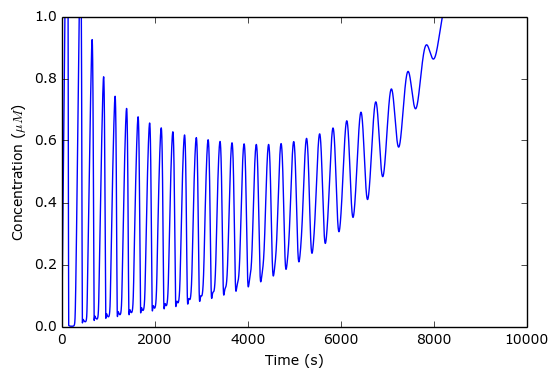

In [3]:
(t,Ra) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra)
plt.xlim([0,10000])
plt.ylim([0,1.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.show()

## <u>Comparison</u>

We are comparing based on the qualitative features of dorsal closure.  We are prioritizing the features of 

1) Early Phase ($t \in [0,2700s)$) - Oscillations

2) Slow Phase ($t \in [2700,7600s)$)- Dampening oscillations and an onset of the ratchet

3) Fast Phase ($t>7600s$)- Cessation of oscillations and growth of active Regulator causing cell area loss.

In the baseline (above) we can clearly see these four features.

Running full simulations of the mechanical model is time consuming and we therefore plot active Regulator as a prediction of what the qualitative features in the model will look like. 

### Raising k1

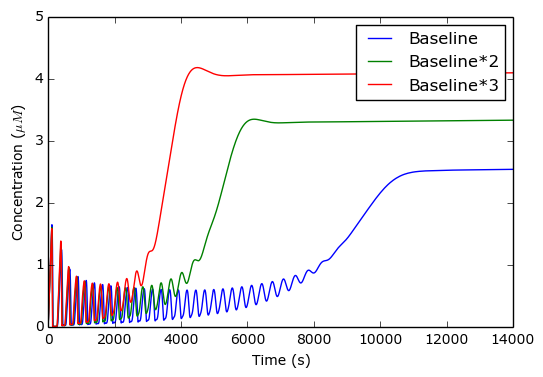

In [4]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125*2,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125*3,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*2')
plt.plot(t, Ra3,label='Baseline*3')
plt.xlim([0,14000])
plt.ylim([0,5.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Raising k1 moves the onset of the fast phase too soon, but otherwise keeps the other features.

### Lowering k1

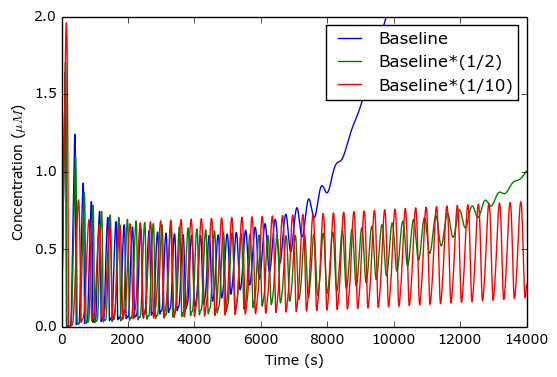

In [5]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125*(1/2.),75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125*(1/10.),75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*(1/2)')
plt.plot(t, Ra3,label='Baseline*(1/10)')
plt.xlim([0,14000])
plt.ylim([0,2.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Lowering k1 causes oscillations to persist too long and fails to bring about onset of the fast phase.  The red line would have the embryo fail to close and also fails to have a discernible ratchet.

### Raising k2

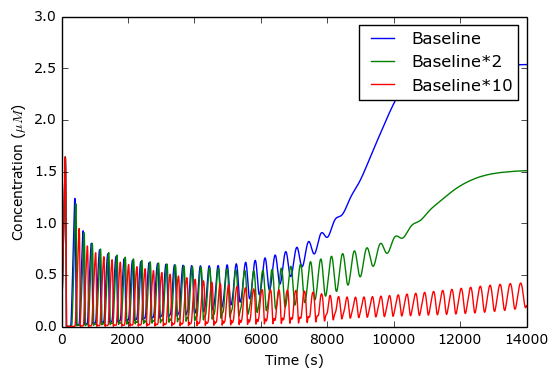

In [6]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125,75.*2,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125,75.*10,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*2')
plt.plot(t, Ra3,label='Baseline*10')
plt.xlim([0,14000])
plt.ylim([0,3.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Raising k2 delays onset of the fast phase and causes oscillations to persist for too long.  The green and red lines would cease to see closure.  The red line would not have a discernible ratchet affect.  

### Lowering k2

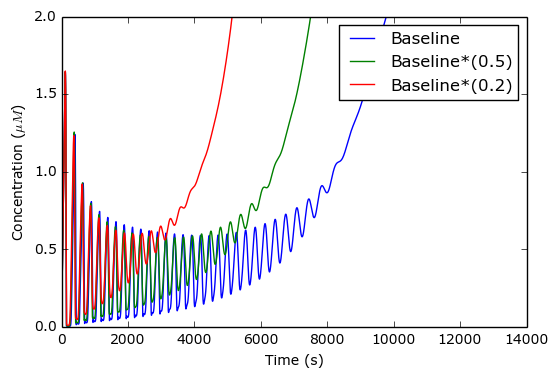

In [7]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125,75.*.5,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125,75.*0.2,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*(0.5)')
plt.plot(t, Ra3,label='Baseline*(0.2)')
plt.xlim([0,14000])
plt.ylim([0,2.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Lowering k2 moves the onset of the fast phase too soon.  It also makes the ratchet more pronounced.

### Raising k3

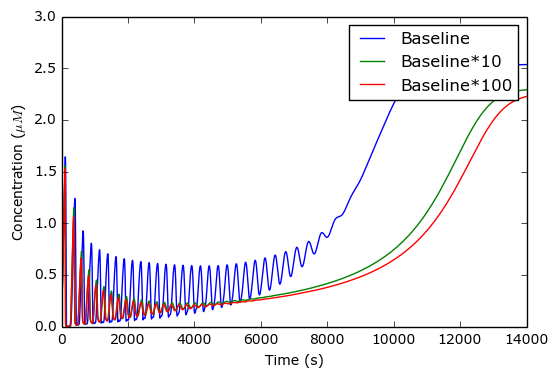

In [8]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125,75.,2.5*10,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125,75.,2.5*100,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*10')
plt.plot(t, Ra3,label='Baseline*100')
plt.xlim([0,14000])
plt.ylim([0,3.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Raising k3 causes the oscillations to be dampened too soon.  Would have a slight ratchet.  Onset of fast phase remains relative intact.  

### Lowering k3

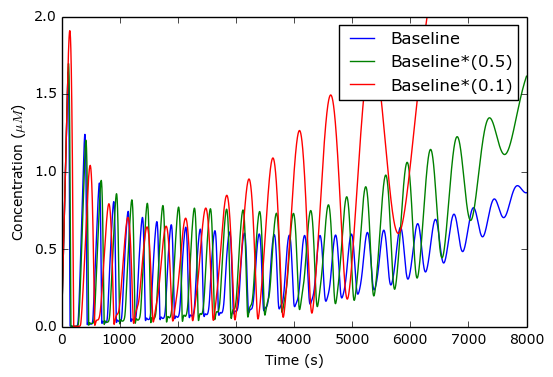

In [9]:
(t1,Ra1) = dde_baz_cluster(0.00125,75.,2.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t2,Ra2) = dde_baz_cluster(0.00125,75.,2.5*0.5,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
(t3,Ra3) = dde_baz_cluster(0.00125,75.,2.5*0.1,0.00125,5.,0.0001,3.5,0.00001,0.015,100.,3.0,3.0)
plt.plot(t, Ra1,label='Baseline')
plt.plot(t, Ra2,label='Baseline*(0.5)')
plt.plot(t, Ra3,label='Baseline*(0.1)')
plt.xlim([0,8000])
plt.ylim([0,2.0])
plt.xlabel("Time (s)")
plt.ylabel('Concentration ($\mu M$)')
plt.legend()
plt.show()

Lowering k3 ruins the dampening of the oscillations and the amplitude of oscillations would actually increase at the end of the slow phase.

### Raising k4